In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

import os
import Image_prep
import importlib
importlib.reload(Image_prep)
from PIL import Image

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Dropout,Flatten
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix

In [17]:
#Initially we have the data grouped in two directories corresponding to each of the classes
mask_dir="facemask_images/with_mask"
nomask_dir="facemask_images/without_mask"

In [18]:
#We need to run the lines below only once to create folders fro training, validation and testing that included folders for each of the two classes
#Image_prep.train_test_data_sep("with_mask","without_mask","facemask_images",bigdir_name="train",smalldir_name="check",test_fraction=0.3)
#Image_prep.train_test_data_sep("with_mask","without_mask","facemask_images/check",bigdir_name="valid",smalldir_name="test",test_fraction=0.3)

In [19]:
train_dir="facemask_images/train/"
valid_dir="facemask_images/check/valid/"
test_dir="facemask_images/check/test/"

In [20]:
#Get average height and width of the images to choose optimal size

In [21]:
Image_prep.calculate_average_pixel_size(train_dir+"without_mask")

Average image size: 323.25 x 396.85833333333335 pixels


In [22]:
Image_prep.calculate_average_pixel_size(train_dir+"with_mask")

Average image size: 346.597510373444 x 414.32365145228215 pixels


In [23]:
# we need to resize all the images to the same size for training of the model
image_shape=(300,300,3)

In [24]:
#Lets display one of the images
os.listdir(train_dir+"with_mask")[0]

'1-with-mask.jpg'

In [25]:
im_mask=plt.imread(train_dir+"with_mask/1-with-mask.jpg")

In [26]:
im_mask.shape

(350, 525, 3)

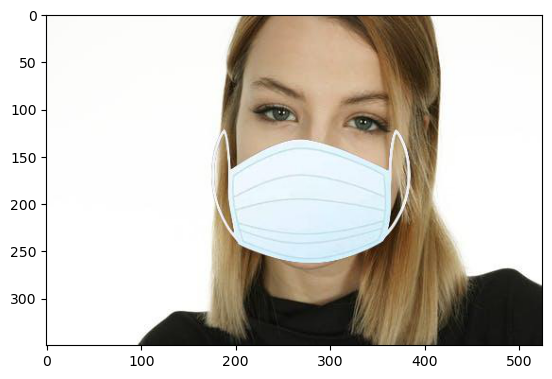

In [27]:
plt.imshow(im_mask)

# Model

In [28]:
model=Sequential()

model.add(Conv2D(filters=32,kernel_size=(3,3),input_shape=image_shape,activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=32,kernel_size=(3,3),input_shape=image_shape,activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))


model.add(Conv2D(filters=32,kernel_size=(3,3),input_shape=image_shape,activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(128,activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(1,activation='sigmoid'))

model.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 149, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 73, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 35, 35, 32)       0

In [30]:
early_stop=EarlyStopping(monitor="val_loss",patience=2)

In [31]:
batch_size=16 #power of two

In [32]:
#Defining data generators to read the pictures and store in float32 tensors
image_gen=ImageDataGenerator(rotation_range=20,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             shear_range=0.1, #cutting away part of the image
                             zoom_range=0.1,
                             horizontal_flip=True, #randomly allow horizontal flipping
                             fill_mode="nearest", # if you are stretching pictue use numbers in neighbouring cells
                             rescale=1/255  # need this to normalize image 0-255 to be 0-1 
                             )  #expand amount of images: rotate randomly images for up to 20 Deg, shifth the width of the image randomly up to 10%

In [33]:
train_image_gen=image_gen.flow_from_directory(train_dir,
                                              target_size=image_shape[:2],
                                              color_mode="rgb",
                                              batch_size=batch_size,
                                            class_mode="binary") #shuffling to avoid any overfitting in training

Found 962 images belonging to 2 classes.


In [34]:
valid_image_gen=image_gen.flow_from_directory(valid_dir,
                                              target_size=image_shape[:2],
                                              color_mode="rgb",
                                             batch_size=batch_size,
                                             class_mode="binary",
                                             shuffle=False) #during inference (validation/test) there is no training thus no shuffling.

Found 289 images belonging to 2 classes.


In [35]:
test_image_gen=image_gen.flow_from_directory(test_dir,
                                              target_size=image_shape[:2],
                                              color_mode="rgb",
                                             batch_size=batch_size,
                                             class_mode="binary",
                                             shuffle=False) #during inference (validation/test) there is no training thus no shuffling.

Found 125 images belonging to 2 classes.


In [36]:
train_image_gen.class_indices

{'with_mask': 0, 'without_mask': 1}

In [37]:
results=model.fit_generator(train_image_gen,epochs=20,
                           validation_data=valid_image_gen,
                           callbacks=[early_stop])

C:\Users\17573\anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/20
61/61 [==============================] - 50s 807ms/step - loss: 0.4563 - accuracy: 0.7775 - val_loss: 0.2040 - val_accuracy: 0.9481
Epoch 2/20
61/61 [==============================] - 50s 810ms/step - loss: 0.2334 - accuracy: 0.9272 - val_loss: 0.1599 - val_accuracy: 0.9550
Epoch 3/20
61/61 [==============================] - 52s 850ms/step - loss: 0.1463 - accuracy: 0.9459 - val_loss: 0.3034 - val_accuracy: 0.9308
Epoch 4/20
61/61 [==============================] - 52s 852ms/step - loss: 0.1515 - accuracy: 0.9522 - val_loss: 0.0867 - val_accuracy: 0.9689
Epoch 5/20
61/61 [==============================] - 54s 876ms/step - loss: 0.1118 - accuracy: 0.9563 - val_loss: 0.0948 - val_accuracy: 0.9689
Epoch 6/20
61/61 [==============================] - 54s 876ms/step - loss: 0.0905 - accuracy: 0.9719 - val_loss: 0.0775 - val_accuracy: 0.9654
Epoch 7/20
61/61 [==============================] - 55s 890ms/step - loss: 0.0695 - accuracy: 0.9782 - val_loss: 0.0653 - val_accuracy: 0.9758

In [38]:
losses=pd.DataFrame(model.history.history)

In [39]:
eval_obj=Image_prep.model_eval(model,test_image_gen)

8/8 [==============================] - 3s 418ms/step
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        63
           1       0.97      0.97      0.97        62

    accuracy                           0.97       125
   macro avg       0.97      0.97      0.97       125
weighted avg       0.97      0.97      0.97       125



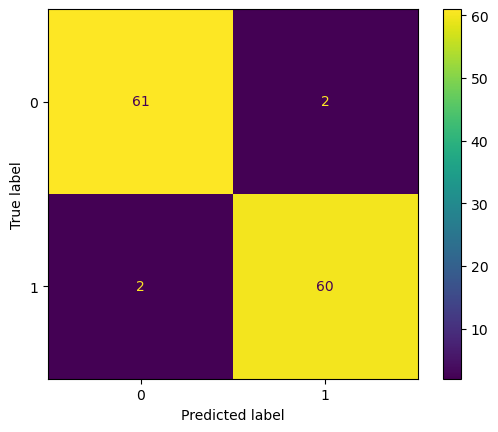

In [40]:
eval_obj.model_pred()

Plotting image for lossesIndex(['loss', 'accuracy', 'val_loss', 'val_accuracy'], dtype='object')


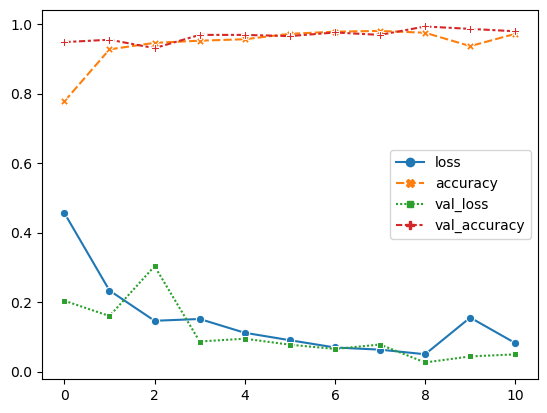

In [41]:
eval_obj.loss_plot(losses)

In [50]:
#Lets display one of the images
os.listdir(test_dir+"with_mask")[2]

'121-with-mask.jpg'

In [52]:
mask_cell=test_dir+"with_mask/121-with-mask.jpg"

1/1 [==============================] - 0s 27ms/step


{'with_mask'}

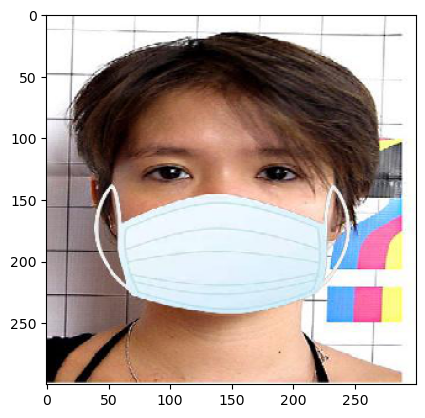

In [53]:
eval_obj.pred_img_class(mask_cell,image_shape)

In [49]:
model.save("Mask_model.h5")